**Initialization**

*Setting up Fast.ai Environment*

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Downloading the Dependencies**

In [3]:
from fastai.basics import  *
from fastai.tabular import  *

**Data Preparation**

In [4]:
path = Config.data_path()
path.mkdir(parents=True, exist_ok=True)
path.ls()

[PosixPath('/root/.fastai/data/train_clean'),
 PosixPath('/root/.fastai/data/test_clean')]

In [5]:
cd data

/root/.fastai/data


In [6]:
train_df = pd.read_pickle(path/"train_clean")

In [7]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
SchoolHoliday_bw,5,5,5,5,5
Promo_bw,5,5,5,5,5
StateHoliday_fw,0,0,0,0,0
SchoolHoliday_fw,7,1,5,1,1


In [8]:
n = len(train_df)
n

844338

**Experimenting with Sample**

In [10]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ["CompetitionDistance", "Mean_Humidity"]
small_cat_vars = ["Store", "DayOfWeek", "PromoInterval"]
small_train_df = small_train_df[small_cont_vars + small_cat_vars + ["Sales"]]
small_test_df = small_test_df[small_cont_vars + small_cat_vars + ["Sales"]]

In [11]:
small_train_df.head()

,CompetitionDistance,Mean_Humidity,Store,DayOfWeek,PromoInterval,Sales
1179,410.0,60,67,4,NaN,10875
1250,25360.0,51,138,4,NaN,10018
1333,13530.0,86,221,4,NaN,6865
1703,2540.0,73,592,4,NaN,5259
3055,800.0,67,831,3,NaN,14535


In [12]:
small_test_df.head()

,CompetitionDistance,Mean_Humidity,Store,DayOfWeek,PromoInterval,Sales
420039,2060.0,55,357,3,NaN,8427
420160,1940.0,57,478,3,NaN,8166
420226,250.0,55,544,3,"Jan,Apr,Jul,Oct",16789
420853,420.0,64,57,2,NaN,15308
420875,3320.0,55,79,2,NaN,7001


In [13]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [14]:
small_test_df.head(10)

,CompetitionDistance,Mean_Humidity,Store,DayOfWeek,PromoInterval,Sales
420039,2060.0,55,NaN,3,NaN,8427
420160,1940.0,57,NaN,3,NaN,8166
420226,250.0,55,NaN,3,"Jan,Apr,Jul,Oct",16789
420853,420.0,64,57,2,NaN,15308
420875,3320.0,55,79,2,NaN,7001
420960,1160.0,72,164,2,"Jan,Apr,Jul,Oct",6155
421275,320.0,64,479,2,"Feb,May,Aug,Nov",13510
421957,270.0,78,NaN,1,"Jan,Apr,Jul,Oct",12082
422107,4210.0,78,NaN,1,NaN,9761
422200,4150.0,54,NaN,1,NaN,12505


In [15]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [17]:
small_train_df["PromoInterval"].cat.codes[:10]

1179   -1
1250   -1
1333   -1
1703   -1
3055   -1
3114    0
3395   -1
3416    0
3851    1
4088   -1
dtype: int8

In [18]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [19]:
small_train_df[small_train_df["CompetitionDistance_na"] == True]

,CompetitionDistance,Mean_Humidity,Store,DayOfWeek,PromoInterval,Sales,CompetitionDistance_na
87597,2410.0,85,879,2,"Feb,May,Aug,Nov",5037,True


### **Preparing Full-Dataset**

In [20]:
train_df = pd.read_pickle(path/"train_clean")
test_df = pd.read_pickle(path/"test_clean")

In [21]:
len(train_df), len(test_df)

(844338, 41088)

In [22]:
procs = [FillMissing, Categorify, Normalize]

In [23]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

In [24]:
cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [26]:
dep_var = "Sales"
df = train_df[cat_vars + cont_vars + [dep_var, "Date"]].copy()

In [27]:
test_df["Date"].min(), test_df["Date"].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [28]:
cut = train_df["Date"][(train_df["Date"] == train_df["Date"][len(test_df)])].index.max()
cut

41395

In [29]:
valid_idx = range(cut)

In [30]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [31]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
        .split_by_idx(valid_idx)
        .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
        .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
        .databunch())

### **Model**

In [32]:
max_log_y = np.log(np.max(train_df["Sales"])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [33]:
learn = tabular_learner(data, layers=[1000, 500], ps=[0.001, 0.01], emb_drop=0.04,
                        y_range=y_range, metrics=exp_rmspe)

In [34]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(23, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [36]:
len(data.train_ds.cont_names)

16

In [37]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


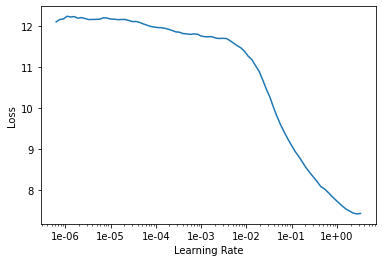

In [38]:
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(5, 1e-02, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.038173,0.032606,0.165591,04:07
1,0.045616,0.032508,0.176910,04:10
2,0.035031,0.029542,0.175270,04:09
3,0.024884,0.023352,0.145440,04:10
4,0.012618,0.013290,0.114635,04:10


In [40]:
learn.save("model-1")

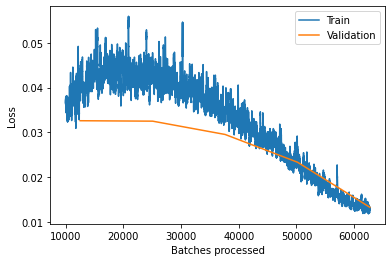

In [41]:
learn.recorder.plot_losses(skip_start=10000)

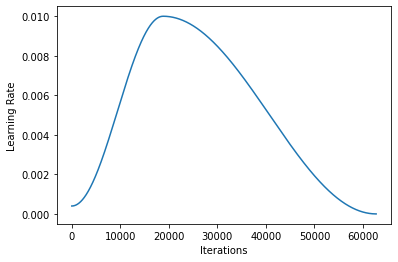

In [42]:
learn.recorder.plot_lr()

**Submission**

In [43]:
test_preds = learn.get_preds(DatasetType.Test)
test_df["Sales"] = np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id", "Sales"]] = test_df[["Id", "Sales"]].astype("int")
test_df[["Id", "Sales"]].to_csv("rossmann_submission.csv", index=False)